# SmolLM Super Weight

Super wight is a single weight in the transformer model that has a disproportional impact on the output - removing it  (just one number from bilions of paramters) lead to significant drop in performance. It was first discovered in paper called "[https://arxiv.org/abs/2411.07191](https://arxiv.org/abs/2411.07191)" as well as method to find it. Supper wieght is not unique to a specific model and can be found in any transformer model, and it remain after instruct fine-tuning. In this notebook we will try to find the super weight in the SmolLM2 model.

### Load model

In [ ]:
from typing import Sequence
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B"
device = "cuda" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

In [3]:
model.model.layers

ModuleList(
  (0-23): 24 x LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  )
)

In [4]:
num_layers = len(model.model.layers)
num_layers

24

## Super weight identification

 The method for identifying super weights is based on the finding that super weights create super activations. Super activations are exceptionally massive activations observed in LLMs that persist across many layers, have constant magnitude, and always exist at the same position regardless of input. The activation's channel aligns with the super weight's channel, and the super activation first appears right after the super weight. Pruning the super weight drastically reduces the magnitude of this massive activation, suggesting a causal link.

Super weights can be located by detecting the spikes in the inputs and outputs distributions of the `mlp.down_proj` module across different layers. This detection process is efficient and requires only a single input prompt, not a full validation dataset. First, we need to save input and output activations for each layer:

In [5]:
model.get_submodule(f"model.layers.2.mlp.down_proj")

Linear(in_features=8192, out_features=2048, bias=False)

In [6]:
#lists to store inputs and outputs activations
all_inputs = []
all_outputs = []
hooks = []

# Register the hook for each layer
for i in range(num_layers):
    def save_activations_hook(module, inputs, outputs):
        if isinstance(inputs, Sequence):
            inputs = inputs[0]
        all_inputs.append(inputs.cpu())
        all_outputs.append(outputs.cpu())
    layer = model.get_submodule(f"model.layers.{i}.mlp.down_proj")
    hooks.append(layer.register_forward_hook(save_activations_hook))

In [7]:
with torch.no_grad():
    inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
    outputs = model(inputs[:, :1])

In [8]:
len(all_inputs), len(all_outputs)

(24, 24)

Plot the extreme outliers in the input and output activations of the mlp.down_proj module for all transformer layers

In [9]:
max_input_activations = [inp_act.abs().max().item() for inp_act in all_inputs]
max_output_activations = [out_act.abs().max().item() for out_act in all_outputs]

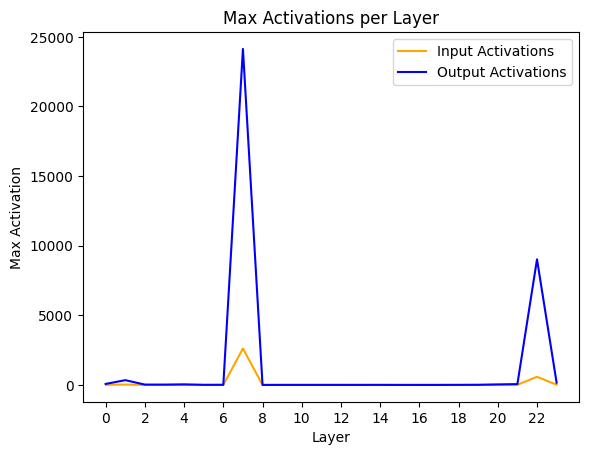

In [10]:
import matplotlib.pyplot as plt

plt.plot(max_input_activations, label="Input Activations", color="orange")
plt.plot(max_output_activations, label="Output Activations", color="blue")
plt.xlabel("Layer")
plt.ylabel("Max Activation")
plt.title("Max Activations per Layer")
plt.xticks(range(0, num_layers, 2))
plt.legend()
plt.show()

We can see that super activations first appear after layer 1 output So, the super weight must be in layer 1. Lets find it!

Specifically, for a given layer, the channel index of the large maximum-magnitude activation in the down_proj input indicates the row of the super weight.
The channel index of the large maximum-magnitude activation in the down_proj output in the same layer indicates the column of the super weight.

In [11]:
all_outputs[1].abs().max(dim=-1)

torch.return_types.max(
values=tensor([[342.2404]]),
indices=tensor([[749]]))

In [12]:
all_inputs[1].abs().max(dim=-1)

torch.return_types.max(
values=tensor([[26.4583]]),
indices=tensor([[4987]]))

So the super weight is [749, 4987] of mlp down_proj from layer 1. Lets check that it actually is a super weight by looking at the activations it produces in each layer.

In [13]:
super_activations = [abs(act[0, -1, 749]) for act in all_outputs]


/tmp/ipykernel_1625/3639201231.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


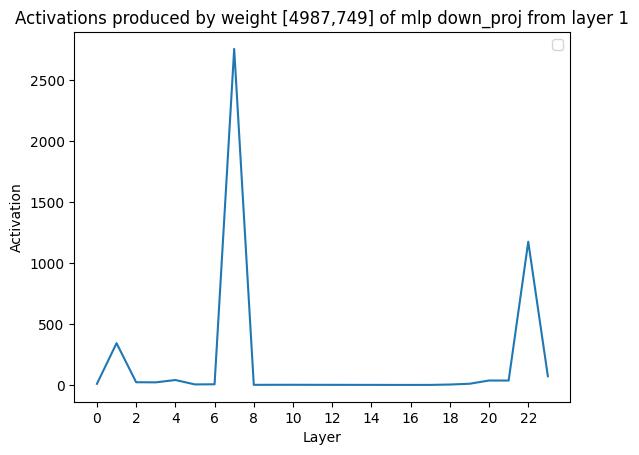

In [14]:
plt.plot(super_activations)
plt.xlabel("Layer")
plt.ylabel("Activation")
plt.title("Activations produced by weight [4987,749] of mlp down_proj from layer 1")
plt.xticks(range(0, num_layers, 2))
plt.legend()
plt.show()

We can see from that output activations produced by the weight [749, 4987] of mlp down_proj from layer 1 are match to maximum output activations from plot above.

## Calculate perplexity on Wiki-2

Removing super weight lead to model performance drop. To demonstrate it lets calculate perplexity on wikitext dataset. Perplexity is defined as the exponentiated average negative log-likelihood of a sequence. If we have a tokenized
sequence $X = (x_0, x_1, \dots, x_t)$, then the perplexity of $X$ is,

$$\text{PPL}(X) = \exp \left\{ {-\frac{1}{t}\sum_i^t \log p_\theta (x_i|x_{<i}) } \right\}$$

where $\log p_\theta (x_i|x_{<i})$ is the log-likelihood of the ith token conditioned on the preceding tokens $x_{<i}$ according to our model. Lower perplexity means better performance. You can learn more about perplexity [here](https://huggingface.co/docs/transformers/en/perplexity).

But first of all, we need to remove our hooks to avoid memory leak due to storing activations in all_inputs and all_outputs lists.

In [15]:
for hook in hooks:
    hook.remove()

Lets just try to run initial model and model with super weight set to 0 on simple example and see how it looks like:

In [16]:
inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(f"Initial output: {tokenizer.decode(outputs[0])}")
super_wight_value = model.model.layers[1].mlp.down_proj.weight[749, 4987].item()
with torch.no_grad():
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
    outputs = model.generate(inputs)
    print(f"Output with weight [4987,749] set to 0: {tokenizer.decode(outputs[0])}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_wight_value

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Initial output: Transformer architecture is a type of neural network that is used for unsupervised learning. It is a type of neural network that
Output with weight [4987,749] set to 0: Transformer architecture isControlPlane of <jupyter_script>./. . . . . . . . . . . . . . .


We can see that the weight [749, 4987] is important for the model to generate the correct answer - without it model produce complitle different answer. Now lets load dateset and evaluate the model on it.

In [ ]:
from datasets import load_dataset

test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
data = tokenizer("\n\n".join(test["text"]), return_tensors="pt", add_special_tokens=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (304978 > 8192). Running this sequence through the model will result in indexing errors


In [18]:
max_length = 8192
stride = 4086
seq_len = data.input_ids.size(1)
max_length, stride, seq_len



(8192, 4086, 304978)

In [19]:
from tqdm import tqdm

@torch.no_grad()
def calculate_perplexity(model, encodings):
    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0

    # calculations are based on https://huggingface.co/docs/transformers/en/perplexity#example-calculating-perplexity-with-gpt-2-in--transformers
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop

        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
    
        outputs = model(input_ids, labels=target_ids)

        neg_log_likelihood = outputs.loss # loss is calculated using CrossEntropyLoss which averages over valid labels
    
        # Accumulate the total negative log-likelihood and the total number of tokens
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens

        prev_end_loc = end_loc
        del input_ids
        if end_loc == seq_len:
            break
    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    ppl = torch.exp(avg_nll)
    return ppl.item()


In [20]:

ppl=calculate_perplexity(model, data)
print(f"Initial perplexity: {ppl}")
with torch.no_grad():
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
ppl = calculate_perplexity(model, data)
print(f"Perplexity with weight [4987,749] set to 0: {ppl}")


 97%|█████████▋| 73/75 [00:54<00:01,  1.35it/s]


Initial perplexity: 6.928025722503662


 97%|█████████▋| 73/75 [00:54<00:01,  1.34it/s]

Perplexity with weight [4987,749] set to 0: 90726536.0


We can see that removing the super wighthas a significant impact on the perplexity - it increased on several orders of magnitude. This is exactly what we expected according to original paper results. 

In [21]:
del data
del model
torch.cuda.empty_cache()

Now lets check instruct model - super weight should remain on the same position. To check it we will evaluate two verions of model on hellaswag dataset.

## Instruct model evaluation

In [22]:
from datasets import load_dataset

dataset = load_dataset("hellaswag", split="validation")
#dataset = load_dataset("hellaswag", split="test")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/6.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/39905 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10042 [00:00<?, ? examples/s]

In [25]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B-Instruct"

device = "cuda" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

First, lets just try to ask both original and modified model the same question and see if there is any difference in the output.

In [ ]:
messages = [{"role": "user", "content": "What is the capital of France?"}]
input_text=tokenizer.apply_chat_template(messages, tokenize=False)
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
super_weight_value = model.model.layers[1].mlp.down_proj.weight[749, 4987].item()
with torch.no_grad():
    outputs = model.generate(inputs, max_new_tokens=50, temperature=0.2, top_p=0.9, do_sample=True)
    print(f"Initial output: {tokenizer.decode(outputs[0])}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    outputs = model.generate(inputs, max_new_tokens=50, temperature=0.2, top_p=0.9, do_sample=True)
    print(f"Output with weight [749, 4987] set to 0: {tokenizer.decode(outputs[0])}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_weight_value

Initial output: <|im_start|>system
You are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>
<|im_start|>user
What is the capital of France?<|im_end|>
<|im_start|>assistant
The capital of France is Paris.<|im_end|>
Output with weight [749, 4987] set to 0: <|im_start|>system
You are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>
<|im_start|>user
What is the capital of France?<|im_end|>
<|im_end|>


Same situation here - after removing super weight, the model doesn't generate correct answer. Now, lets calculate accuracy on hellaswag dataset. First we need to define few function for preprocessing data, constructing prompts, generate answers, and evaluating it.

In [23]:
# code from https://github.com/pchizhov/hellaswag-evaluation/blob/main/evaluation_scripts/evaluate_generation.py
import torch
import json
import re
import datasets
import random


def preprocess(text):
    text = text.strip()
    # NOTE: Brackets are artifacts of the WikiHow dataset portion of HellaSwag.
    text = text.replace(" [title]", ". ")
    text = re.sub("\[.*?\]", "", text)
    text = text.replace("  ", " ")
    return text


def process_docs(dataset: datasets.Dataset, eval_type='full') -> datasets.Dataset:
    def _process_doc(doc):
        if eval_type == 'full':
            ctx = doc["ctx_a"] + " " + doc["ctx_b"].capitalize()
        else:
            ctx = doc["ctx_b"].capitalize()
        choices = [preprocess(ending) for ending in doc["endings"]]
        gold_index = int(doc["label"])

        indices = list(range(len(choices)))
        random.shuffle(indices)
        shuffled_choices = [choices[i] for i in indices]
        new_gold_index = indices.index(gold_index)

        if eval_type == 'full':
            query = preprocess(doc["activity_label"] + ": " + ctx)
        else:
            query = preprocess(ctx)

        out_doc = {
            "query": query,
            "choices": shuffled_choices,
            "gold": new_gold_index,
        }
        return out_doc

    return dataset.map(_process_doc)


def construct_prompt(context, endings):
    prompt = (
        "You are given a situation followed by four possible endings. "
        "Choose the most appropriate ending by selecting the corresponding number. "
        "Respond only with the number of the correct answer.\n\n"
        f"Context: {context}\n"
    )
    for i, ending in enumerate(endings):
        prompt += f"{i +1}. {ending}\n"
    prompt += "\nAnswer: "
    return prompt


def generate_answer(model, prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=inputs.input_ids.shape[1] + 1)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    return answer.split("Answer:")[-1].strip().replace(".", "")


def compute_real_accuracy(filename):
    with open(filename, "r") as f:
        data = json.load(f)

    correct = 0
    for question in data:
        digits = [a for a in question['generated_answer'] if a in '1234']
        if len(digits) == 0:
            ## print('ERROR:', question)
            pass
        else:
            correct += int(digits[0] == question['correct_answer'])

    return correct / len(data)

<>:13: SyntaxWarning: invalid escape sequence '\['
<>:13: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_1625/227691419.py:13: SyntaxWarning: invalid escape sequence '\['
  text = re.sub("\[.*?\]", "", text)


And evaluation function itself

In [ ]:
dataset = process_docs(dataset)


@torch.no_grad()
def evaluate(model, total=2500):
    correct = 0
    results = []
    for i in tqdm(range(total)):
        example = dataset[i]
        context = example["query"]
        endings = example["choices"]
        correct_answer = str(example["gold"] + 1)  # Labels are 0-indexed
        prompt = construct_prompt(context, endings)
        generated_answer = generate_answer(model, prompt)
        # print(prompt, generated_answer, correct_answer)

        results.append({
            "context": context,
            "options": endings,
            "correct_answer": correct_answer,
            "generated_answer": generated_answer
        })

        if correct_answer == generated_answer:
            correct += 1

    accuracy = correct / total
    print(f"Initial Accuracy: {accuracy:.2%}")

    filename = f"data/hellaswag_SmalLM2.json"

    with open(filename, "w") as f:
        json.dump(results, f, indent=4)


    real_accuracy = compute_real_accuracy(filename)
    print(f"Real Accuracy: {real_accuracy:.2%}")
    return real_accuracy

Map:   0%|          | 0/10042 [00:00<?, ? examples/s]

In [ ]:

print(f"Initial accuracy: {evaluate(model)}")
super_weight_value = model.model.layers[1].mlp.down_proj.weight[749, 4987].item()
with torch.no_grad():
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
print(f"Accuracy with weight [4987,749] set to 0: {evaluate(model)}")
with torch.no_grad():
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_weight_value


100%|██████████| 2500/2500 [00:56<00:00, 44.39it/s]


Initial Accuracy: 42.80%
Real Accuracy: 42.80%
Initial accuracy: 0.428


100%|██████████| 2500/2500 [00:56<00:00, 44.37it/s]


Initial Accuracy: 23.44%
Real Accuracy: 23.44%
Accuracy with weight [4987,749] set to 0: 0.2344


So we can see that supper weight is still preserved in instruct model - after removing it accuracy dropped almost twice. Now, lets try to see how supper weight work.

In [ ]:
del model
del dataset

## How the supper wight work

This section is based on [A Mathematical Framework for Transformer Circuits](https://transformer-circuits.pub/2021/framework/index.html), and credits for images here go to the authors of the paper. It is quite long reading, but it is very well written and I highly recommend it to anyone interested in how transformers work internally.

First, lets remember main components of transormer architecture:

![image.png](https://github.com/aerubanov/SmolLMSuperWeight/blob/main/images/image1.png)

A transformer starts with a token embedding, followed by a series of “residual blocks”, and finally a token unembedding. Each residual block consists of an attention layer, followed by an MLP layer. Both the attention and MLP layers each “read” their input from the residual stream (by performing a linear projection), and then “write” their result to the residual stream by adding a linear projection back in. 

Residual stream work as a comunication channel between layers. Once added, information persists in a subspace unless another layer actively deletes it. From this perspective, dimensions of the residual stream become something like "memory" or "bandwidth". But what control this information flow between layers?

One can think of implicit "virtual weights" directly connecting any pair of layers (even those separated by many other layers), by multiplying out their interactions through the residual stream. These virtual weights are the product of the output weights of one layer with the input weights of another (ie. $W_{I}^2W_{O}^1$), and describe the extent to which a later layer reads in the information written by a previous layer.

![image2.png](https://github.com/aerubanov/SmolLMSuperWeight/blob/main/images/image2.png)

Now, lets remember that super wieght is located in drop down proj layer of mlp in first residual block. It is common location for super weights - it found here in other models too, only position within layer is different. Also, we saw in example above that after removing super weight, model start produce output filled with stop words: dots, commas and special tokens. It is also common behavior. 

Combianing this observation with our knowledge about transformrs internals, we can came to following explanation: transformer model have a mechanism which is responsible for decision to put stop word at current position of generated sequence or not, which is located in the first residual block. Most likly because it has direct accese to input sequence - and it is all that model need to know to decide if it is time to stop (because sentence is complete). But then model need to pass the information through the rest of the model, and here the super wights come into play.

Weights of drop down projection are responsible for writing data in residual stream, and super weight produce super activtion so subsequent layers can not owerwrite it. When model do not decide to put stop word, super activation should suppres stop words probabilities. When model decide to put stop word, it just not produce super activation and therefore stop word probabilities are not supressed.

We can check this idea by comparing token probabilities before and after dropping the super weight.

## Tokens probabilities calculation

In [31]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B"
device = "cuda" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

First, we need a function which will calculate probabilities for next token:

In [32]:
def get_next_token_probs(model, tokenizer, input_text, target_tokens=None):
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(model.device)
    selcted_prob = []
    # Get model outputs
    with torch.no_grad():
        outputs = model(input_ids)
            
        # Get the logits for the next token prediction
        next_token_logits = outputs.logits[:, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        
        if target_tokens is None:
            return next_token_probs
        for i in target_tokens:
            selcted_prob.append(next_token_probs[0, i].item())

    return selcted_prob

Now, lets select to 30 most probable tokens and see how they are affected by the super weight:

In [ ]:
import torch
from datasets import load_dataset
from tqdm import tqdm



N_SAMPLES = 500
top_n = 30
dataset = load_dataset("EleutherAI/lambada_openai", "en", split="test")
all_probs = []

for text in tqdm(dataset["text"][:N_SAMPLES]):
    input_text = text
    probabilities = get_next_token_probs(model, tokenizer, input_text)
    
    all_probs.append(probabilities)

avg_prob = (sum(all_probs)  / len(all_probs))[0]
avg_prob = avg_prob.to('cpu')
sorted_prob, sorted_indices = torch.sort(torch.tensor(avg_prob), descending=True) 

top_n_probs = sorted_prob[:top_n].tolist()
target_tokens = sorted_indices[:top_n]

avg_prob = top_n_probs

targets = [tokenizer.decode(t) for t in target_tokens]

100%|██████████| 500/500 [00:06<00:00, 71.82it/s]
/tmp/ipykernel_1625/818226890.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sorted_prob, sorted_indices = torch.sort(torch.tensor(avg_prob), descending=True)


In [ ]:
super_weight_value = model.model.layers[1].mlp.down_proj.weight[749, 4987].item()
with torch.no_grad():
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0

avg_prob_droped = [0 for _ in range(len(target_tokens))]
for text in tqdm(dataset["text"][:N_SAMPLES]):
    input_text = text
    probabilities = get_next_token_probs(model, tokenizer, input_text, target_tokens)
    
    for i, prob in enumerate(probabilities):
        avg_prob_droped[i] += prob

avg_prob_droped = [p / N_SAMPLES for p in avg_prob_droped]
with torch.no_grad():
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_weight_value


100%|██████████| 500/500 [00:07<00:00, 69.76it/s]


[0.20883458751676323,
 0.24372421222363364,
 0.007623741961620135,
 0.012049126006692201,
 0.0012673067494968096,
 0.002761696939045063,
 0.010249845701512331,
 0.011122636918666383,
 0.0045945398816998936,
 0.0052315219250244965,
 0.00724416528645516,
 0.004909075260468151,
 0.002201270191901731,
 0.002363771556392114,
 0.009330683299316168,
 0.0071285083243384575,
 0.0029864060793050335,
 0.0027381327795020245,
 0.0004843464638065741,
 0.0047839362873923486,
 0.0028121703180236965,
 0.0027727936624491216,
 0.0004331863385218282,
 0.00017009118752800577,
 0.0013121271709594544,
 0.0020184524343526606,
 0.0032665269194026387,
 1.104223015578418e-05,
 0.0014891770544600753,
 0.002611657288559893]

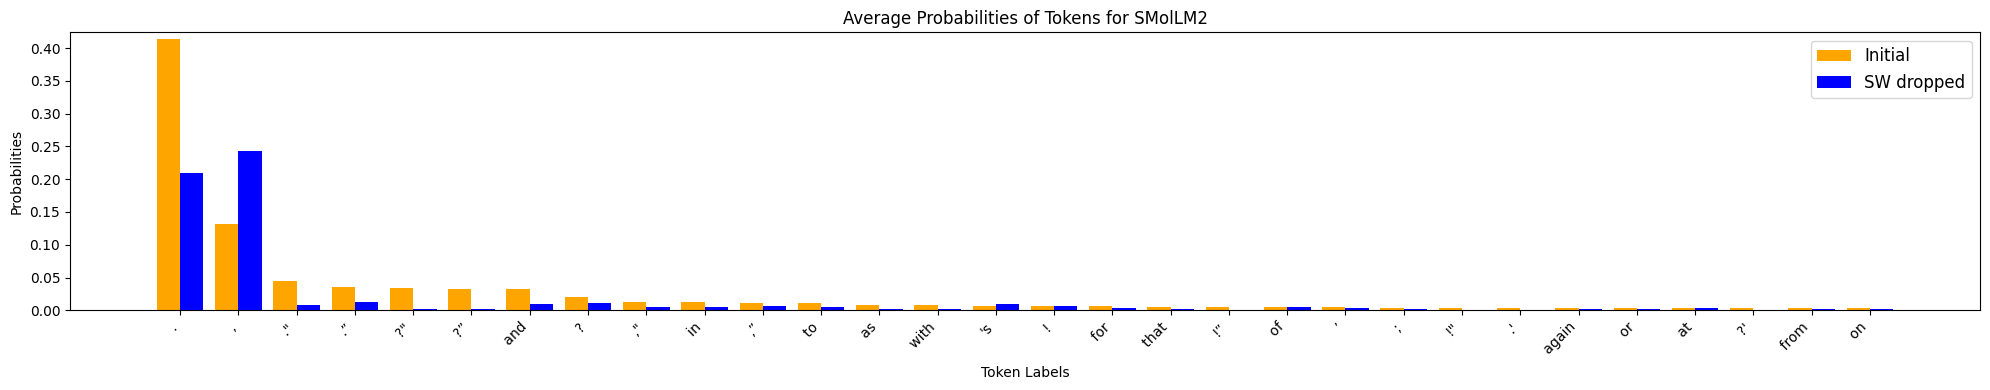

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,4))
plt.xticks(rotation=45, ha="right")

width = 0.4  # Width of the bars
x = range(len(targets))  # X locations for the groups
bars1 = ax.bar([i - width/2 for i in x], avg_prob, width, label="Initial", color='orange', zorder=2)
bars2 = ax.bar([i + width/2 for i in x], avg_prob_droped, width, label="SW dropped", color='blue', zorder=2)
ax.set_xlabel('Token Labels')
ax.set_ylabel('Probabilities')
ax.set_title("Average Probabilities of Tokens for SMolLM2")
ax.set_xticks(x)
ax.set_xticklabels(targets)
ax.legend(prop={"size": 12})

    
# add top padding so enough room to show arrow
ax.set_ylim(0, max(max(avg_prob), max(avg_prob_droped)) + 0.01)  # Add 0.1 or another value for padding

plt.tight_layout()

And here are similar plots for other models from original paper:
![image3.png](https://github.com/aerubanov/SmolLMSuperWeight/blob/main/images/image3.png)
![image4.png](https://github.com/aerubanov/SmolLMSuperWeight/blob/main/images/image4.png)

And we can se exactly what we expected - removing the super weight increase probabilities of stop word tokens and decrease probabilities of usual words.

## Useful links

Original paper: https://arxiv.org/abs/2411.07191

Original code: https://github.com/mengxiayu/LLMSuperWeight

A Mathematical Framework for Transformer Circuits by Antropic: https://transformer-circuits.pub/2021/framework/index.html